## Importación de librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from tensorflow.keras.applications import ResNet50
import tensorflow.keras as K
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-05-07 01:02:33.385576: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-07 01:02:33.414197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 01:02:33.839508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


A continuación, para una mayor claridad, estableceremos los parámetros que se usarán durante el entrenamiento, como el número de batchs, directorios e hiperparámetros.

In [2]:
# Número de clases. 2 para la binaria.
NUM_CLASSES = 2
TRAIN_DIR = "trainThumbnails/"
# Número de canales de cada imagen
CHANNELS = 3

IMAGE_RESIZE = 256
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'relu'
OBJECTIVE_FUNCTION = K.losses.BinaryCrossentropy()

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 3

BATCH_SIZE = 32

In [3]:
model = K.Sequential()

inputs = K.Input(shape=(IMAGE_RESIZE, IMAGE_RESIZE, CHANNELS))

baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=inputs)

for layer in baseModel.layers[:170]:
    layer.trainable = False

headModel = baseModel.output
headModel = K.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = K.layers.Flatten(name="flatten")(headModel)
headModel = K.layers.Dense(256, activation="relu")(headModel)
headModel = K.layers.Dropout(0.5)(headModel)
headModel = K.layers.Dense(1, activation=DENSE_LAYER_ACTIVATION)(headModel)

"""
model = K.models.Sequential()
model.add(K.layers.Lambda(lambda x: tf.image.resize(x, (IMAGE_RESIZE, IMAGE_RESIZE))))
model.add(resnet)
model.add(K.layers.GlobalAveragePooling2D())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Flatten())
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.3))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dropout(0.3))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(2, activation='softmax'))
"""
"""
#Still not talking about our train/test data or any pre-processing.

model = K.Sequential()
"""

model = K.models.Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process


2024-05-07 01:02:34.280891: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7060 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
baseModel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 1,054,720 (4.02 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

### Preparación de los datos
Ahora, una vez definido el modelo y la nueva cabecera, debemos de preparar los datos para su lectura. Para ello, debemos tomar las imágenes en sí y el .csv que contiene los metadatos.

In [5]:
df = pd.read_csv('trainSet.csv')

malignant = ['squamous_cell_carcinoma' 'melanoma', 'basal_cell_carcinoma', 'melanoma_metastatis',
             'intraepithelial_carcinoma', 'kaposi_sarcoma', 'angiosarcoma']


def label_func(fname):
    global df
    if (str(fname)[-4:] == ".bmp"):
        el = df.loc[df['image'] == str(fname)[:-4].split("/")[1]]
    else:
        el = df.loc[df['image'] == str(fname).split("/")[1]]

    if (el['class'].values[0]) in malignant:
        return 1
    else:
        return 0


def create_labels(df, dir):
    # Ruta del directorio que deseas listar
    labels = []

    for nombre_directorio, carpetas, archivos in os.walk(dir):
        for pic in archivos:
            if str(pic)[-4:] == ".bmp":
                el = df.loc[df['image'] == str(pic)[:-4]]
            else:
                el = df.loc[df['image'] == str(pic)]

            if (el['label'].values[0]) in malignant:
                labels.append(1)
            else:
                labels.append(0)

    return labels


In [6]:
train_labels = create_labels(df, TRAIN_DIR)

In [7]:
train_labels2 = np.array(train_labels)

In [8]:
train_ds, valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels=train_labels,
    label_mode='binary',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=19,
    validation_split=0.3,
    subset="both",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 64881 files belonging to 2 classes.
Using 45417 files for training.
Using 19464 files for validation.


In [9]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor='val_loss', patience=EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath='keras_models/best_rs50.keras', monitor='val_loss', save_best_only=True,
                                  mode='auto')

In [10]:
import tensorflow as tfytho

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
# Establecemos la función de pérdida y el optimizador a utilizar.
# Cargamos las métricas a utilizar
model.compile(loss=OBJECTIVE_FUNCTION,
              optimizer=K.optimizers.Adam(learning_rate=1e-5),
              metrics=[
                  K.metrics.BinaryAccuracy(),
                  K.metrics.F1Score(),
                  K.metrics.Recall()
              ]
              )

model.fit(train_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, verbose='auto',
          callbacks=[cb_early_stopper], validation_data=valid_ds,
          shuffle=True)
model.save('keras_models/best_rs50.keras')

Epoch 1/50


I0000 00:00:1715036678.186781  119738 service.cc:145] XLA service 0x7f35f4001f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715036678.186818  119738 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-05-07 01:04:38.321833: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-07 01:04:38.779400: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1715036679.580083  120364 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9389', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1715036679.687943  120367 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5865', 184 bytes spill stores, 524 bytes spill loads

I0000 00:0

   5/1420 ━━━━━━━━━━━━━━━━━━━━ 50s 36ms/step - binary_accuracy: 0.6085 - f1_score: 0.0788 - loss: 4.9405 - recall: 0.1462

I0000 00:00:1715036681.951135  119738 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1420/1420 ━━━━━━━━━━━━━━━━━━━━ 80s 51ms/step - binary_accuracy: 0.8728 - f1_score: 0.0724 - loss: 1.7720 - recall: 0.0317 - val_binary_accuracy: 0.9033 - val_f1_score: 0.0000e+00 - val_loss: 1.5585 - val_recall: 0.0000e+00
Epoch 2/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 68s 48ms/step - binary_accuracy: 0.9002 - f1_score: 0.0083 - loss: 1.5977 - recall: 0.0014 - val_binary_accuracy: 0.9033 - val_f1_score: 0.0000e+00 - val_loss: 1.5585 - val_recall: 0.0000e+00
Epoch 3/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 71s 50ms/step - binary_accuracy: 0.9004 - f1_score: 0.0049 - loss: 1.6003 - recall: 8.5088e-04 - val_binary_accuracy: 0.9033 - val_f1_score: 0.0000e+00 - val_loss: 1.5585 - val_recall: 0.0000e+00
Epoch 4/50
1420/1420 ━━━━━━━━━━━━━━━━━━━━ 71s 50ms/step - binary_accuracy: 0.9003 - f1_score: 0.0030 - loss: 1.6040 - recall: 1.2756e-04 - val_binary_accuracy: 0.9033 - val_f1_score: 0.0000e+00 - val_loss: 1.5585 - val_recall: 0.0000e+00


In [12]:
train_metrics = model.evaluate(valid_ds)


609/609 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - binary_accuracy: 0.9001 - f1_score: 0.0000e+00 - loss: 1.6101 - recall: 0.0000e+00


In [13]:
# Making prediction
y_pred = np.argmax(model.predict(valid_ds), axis=1)

609/609 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step


In [14]:
y_true = []
i=0
for image, label in valid_ds.unbatch():
    y_true.append(int(label[0]))
    i+=1
print(i)


19464


2024-05-07 01:10:21.449693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
from sklearn.metrics import balanced_accuracy_score
balanced_acc = balanced_accuracy_score(y_true, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.3f}")

Balanced Accuracy: 0.500


[[17582     0]
 [ 1882     0]]


ValueError: 'locs' must be 1D with shape (N,), but your input has shape ()

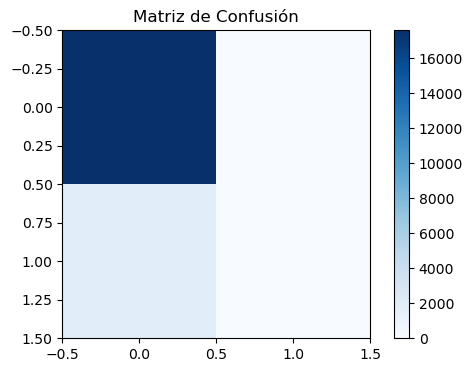

In [16]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
# Visualizamos la matriz de confusión
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.colorbar()
plt.xticks(NUM_CLASSES, NUM_CLASSES, rotation=45)
plt.yticks(NUM_CLASSES, NUM_CLASSES)
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Verdadera")
plt.show()
